In [1]:
# Use seaborn for pairplot.
!pip install -q seaborn

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Make NumPy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

In [3]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

2.8.0


### Get the data
First import the dataset using pandas:

In [4]:
#raw_dataset = pd.read_csv('G_datasets-AEA.csv')

In [5]:
raw_dataset = pd.read_csv('AER_G_dataset-PTC.csv')

In [6]:
dataset = raw_dataset.copy()
dataset.tail()

,DAT(days),Temp,WC,NL,N(PTC) (mg/g),P(PTC) (mg/g),K(PTC) (mg/g),Ca(PTC) (mg/g),Mg(PTC) (mg/g),S(PTC) (mg/g),Na(PTC) (mg/g),Diameter of Bulb(mm)
86,89,29.5,15.18,10.23,43.02,7.56,50.64,14.06,1.83,3.72,1.99,103.39
87,90,27.9,15.21,10.34,43.00,7.64,50.43,14.07,1.84,3.73,2.00,103.47
88,91,27.1,15.27,10.48,42.82,7.68,50.27,14.08,1.85,3.74,2.01,103.49
89,92,26.1,15.30,10.51,42.61,7.72,49.94,14.09,1.86,3.75,2.02,103.52
90,93,26.9,15.37,10.59,42.56,7.74,49.38,14.10,1.87,3.76,2.03,103.66


### Clean the data

The dataset contains a few unknown values:

In [7]:
dataset.isna().sum()

DAT(days)               0
Temp                    0
WC                      0
NL                      0
N(PTC) (mg/g)           0
P(PTC) (mg/g)           0
K(PTC) (mg/g)           0
Ca(PTC) (mg/g)          0
Mg(PTC) (mg/g)          0
S(PTC) (mg/g)           0
Na(PTC) (mg/g)          0
Diameter of Bulb(mm)    0
dtype: int64

Drop those rows to keep this initial tutorial simple:

In [8]:
dataset = dataset.dropna()

### Split the data into training and test sets

Now, split the dataset into a training set and a test set. You will use the test set in the final evaluation of your models.

In [9]:
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

### Inspect the data

Review the joint distribution of a few pairs of columns from the training set.

The top row suggests that the Temperature is a function of all the other parameters. The other rows indicate they are functions of each other.

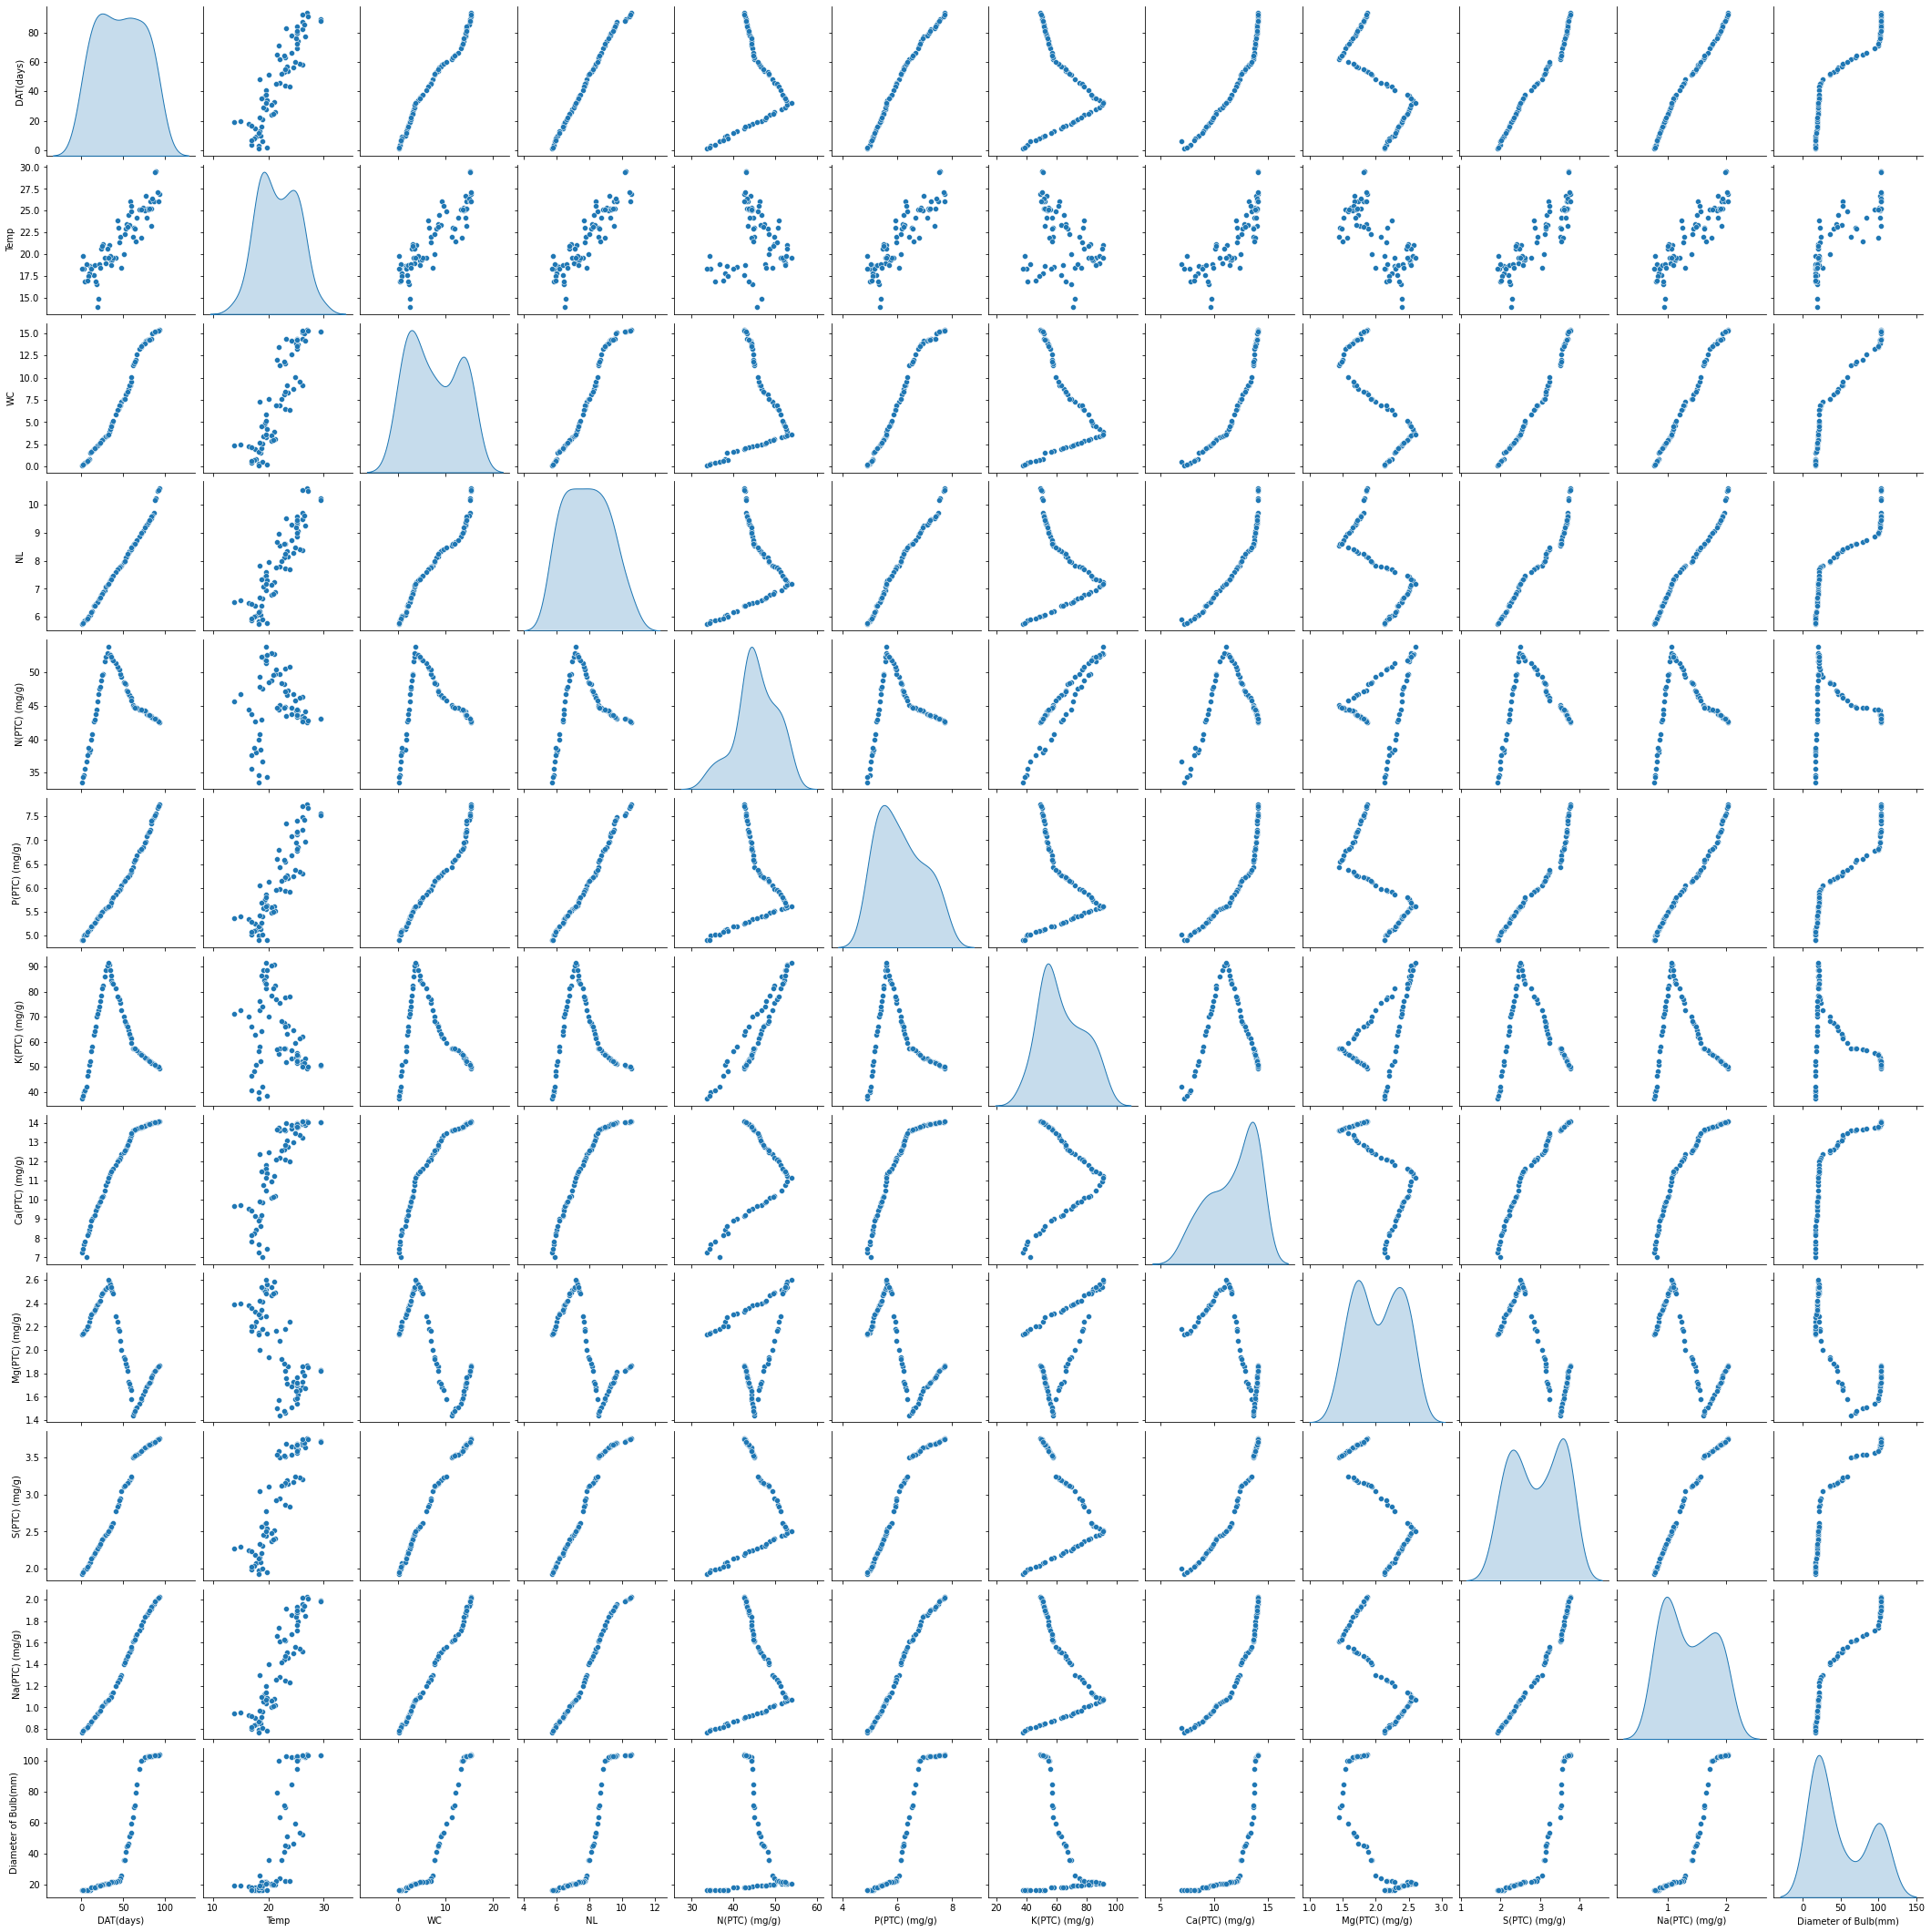

In [10]:
#sns.pairplot(train_dataset[['MPG', 'Cylinders', 'Displacement', 'Weight']], diag_kind='kde')
sns.pairplot(train_dataset[['DAT(days)','Temp','WC','NL','N(PTC) (mg/g)','P(PTC) (mg/g)','K(PTC) (mg/g)','Ca(PTC) (mg/g)','Mg(PTC) (mg/g)','S(PTC) (mg/g)','Na(PTC) (mg/g)','Diameter of Bulb(mm)']]
             ,diag_kind='kde')


Let's also check the overall statistics. Note how each feature covers a very different range:

In [11]:
train_dataset.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
DAT(days),73.0,46.630137,27.651355,1.00,22.00,46.00,71.00,93.00
Temp,73.0,21.753425,3.487481,13.90,18.90,21.50,25.00,29.50
WC,73.0,7.559452,5.236832,0.11,2.70,6.92,13.40,15.37
NL,73.0,7.865616,1.349038,5.75,6.69,7.78,8.95,10.59
N(PTC) (mg/g),73.0,45.369041,4.795538,33.56,43.08,44.70,48.82,53.90
P(PTC) (mg/g),73.0,6.127260,0.825293,4.90,5.43,5.98,6.80,7.74
K(PTC) (mg/g),73.0,63.407260,14.362641,37.29,52.36,59.53,75.47,91.36
Ca(PTC) (mg/g),73.0,11.750000,2.166312,7.01,9.92,12.20,13.79,14.10
Mg(PTC) (mg/g),73.0,2.037945,0.353785,1.44,1.72,2.08,2.36,2.60
S(PTC) (mg/g),73.0,2.916575,0.627774,1.93,2.33,2.94,3.58,3.76


### Split features from labels

Separate the target value—the "label"—from the features. This label is the value that you will train the model to predict.

In [12]:
train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop('Diameter of Bulb(mm)')
test_labels = test_features.pop('Diameter of Bulb(mm)')

## Normalization

In the table of statistics it's easy to see how different the ranges of each feature are:

In [13]:
train_dataset.describe().transpose()[['mean', 'std']]

,mean,std
DAT(days),46.630137,27.651355
Temp,21.753425,3.487481
WC,7.559452,5.236832
NL,7.865616,1.349038
N(PTC) (mg/g),45.369041,4.795538
P(PTC) (mg/g),6.127260,0.825293
K(PTC) (mg/g),63.407260,14.362641
Ca(PTC) (mg/g),11.750000,2.166312
Mg(PTC) (mg/g),2.037945,0.353785
S(PTC) (mg/g),2.916575,0.627774


It is good practice to normalize features that use different scales and ranges.

One reason this is important is because the features are multiplied by the model weights. So, the scale of the outputs and the scale of the gradients are affected by the scale of the inputs.

normalization makes training much more stable.

### The Normalization layer

The `tf.keras.layers.Normalization` is a clean and simple way to add feature normalization into your model.

The first step is to create the layer:

In [14]:
normalizer = tf.keras.layers.Normalization(axis=-1)

Then, fit the state of the preprocessing layer to the data by calling `Normalization.adapt`:

In [15]:
normalizer.adapt(np.array(train_features))

Calculate the mean and variance, and store them in the layer:

In [16]:
print(normalizer.mean.numpy())

[[46.63  21.753  7.559  7.866 45.369  6.127 63.407 11.75   2.038  2.917
   1.355]]


When the layer is called, it returns the input data, with each feature independently normalized:

In [17]:
first = np.array(train_features[:1])

with np.printoptions(precision=2, suppress=True):
  print('First example:', first)
  print()
  print('Normalized:', normalizer(first).numpy())

First example: [[ 3.   18.3   0.31  5.83 34.6   5.01 39.81  7.69  2.15  1.97  0.79]]

Normalized: [[-1.59 -1.   -1.39 -1.52 -2.26 -1.36 -1.65 -1.89  0.32 -1.52 -1.38]]


## Linear regression

Before building a deep neural network model, start with linear regression using one and several variables.

### Linear regression with one variable

Begin with a single-variable linear regression to predict 'Diameter of Bulb' from 'Number of Leaves(NL)'.

There are two steps in your single-variable linear regression model:

- Normalize the `'NL'` input features using the `tf.keras.layers.Normalization` preprocessing layer.
- Apply a linear transformation ($y = mx+b$) to produce 1 output using a linear layer (`tf.keras.layers.Dense`).

The number of _inputs_ can either be set by the `input_shape` argument, or automatically when the model is run for the first time.

First, create a NumPy array made of the `'NL'` features. Then, instantiate the `tf.keras.layers.Normalization` and fit its state to the `NL` data:

In [18]:
NL = np.array(train_features['NL'])

NL_normalizer = layers.Normalization(input_shape=[1,], axis=None)
NL_normalizer.adapt(NL)

Build the Keras Sequential model:

In [19]:
NL_model = tf.keras.Sequential([
    NL_normalizer,
    layers.Dense(units=1)
])

NL_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_1 (Normalizat  (None, 1)                3         
 ion)                                                            
                                                                 
 dense (Dense)               (None, 1)                 2         
                                                                 
Total params: 5
Trainable params: 2
Non-trainable params: 3
_________________________________________________________________


This model will predict `'Diameter of Bulb'` from `'NL'`.

Run the untrained model on the first 10 'Horsepower' values. The output won't be good, but notice that it has the expected shape of `(10, 1)`:

In [20]:
NL_model.predict(NL[:5])

array([[ 0.682],
       [ 0.498],
       [-0.135],
       [ 0.049],
       [-0.792]], dtype=float32)

Once the model is built, configure the training procedure using the Keras `Model.compile` method. The most important arguments to compile are the `loss` and the `optimizer`, since these define what will be optimized (`mean_absolute_error`) and how (using the `tf.keras.optimizers.Adam`).

In [21]:
NL_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')

Use Keras `Model.fit` to execute the training for 100 epochs:

In [22]:
%%time
history = NL_model.fit(
    train_features['NL'],
    train_labels,
    epochs=100,
    # Suppress logging.
    verbose=0,
    # Calculate validation results on 20% of the training data.
    validation_split = 0.2)

Wall time: 4.16 s


Visualize the model's training progress using the stats stored in the `history` object:

In [23]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,val_loss,epoch
95,28.185909,42.939991,95
96,28.013178,42.710281,96
97,27.842390,42.477299,97
98,27.664780,42.246021,98
99,27.489616,42.015244,99


In [24]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 300])
  plt.xlabel('Epoch')
  plt.ylabel('Error [Diameter of Bulb(mm)]')
  plt.legend()
  plt.grid(True)

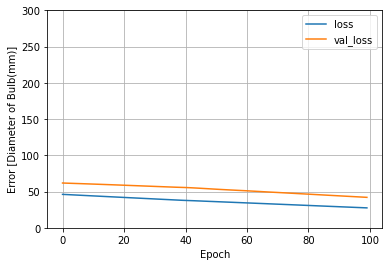

In [25]:
plot_loss(history)

Collect the results on the test set for later:

In [26]:
test_results = {}

test_results['NL_model'] = NL_model.evaluate(
    test_features['NL'],
    test_labels, verbose=0)

Since this is a single variable regression, it's easy to view the model's predictions as a function of the input:

In [27]:
x = tf.linspace(0.0, 12, 12)
y = NL_model.predict(x)

In [28]:
def plot_NL(x, y):
  plt.scatter(train_features['NL'], train_labels, label='Data')
  plt.plot(x, y, color='k', label='Predictions')
  plt.xlabel('NL')
  plt.ylabel('Diameter of Bulb(mm)')
  plt.legend()

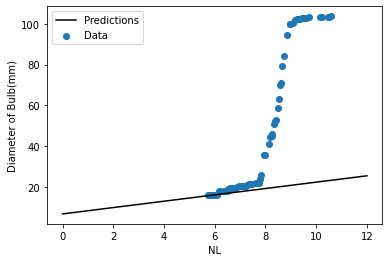

In [29]:
plot_NL(x, y)

### Linear regression with multiple inputs

You can use an almost identical setup to make predictions based on multiple inputs. This model still does the same $y = mx+b$ except that $m$ is a matrix and $b$ is a vector.

Create a two-step Keras Sequential model again with the first layer being `normalizer` (`tf.keras.layers.Normalization(axis=-1)`) you defined earlier and adapted to the whole dataset:

In [30]:
linear_model = tf.keras.Sequential([
    normalizer,
    layers.Dense(units=1)
])

When you call `Model.predict` on a batch of inputs, it produces `units=1` outputs for each example:

In [31]:
linear_model.predict(train_features[:6])

array([[-5.085],
       [-2.444],
       [ 0.693],
       [ 0.845],
       [ 2.206],
       [ 0.969]], dtype=float32)

When you call the model, its weight matrices will be built—check that the `kernel` weights (the $m$ in $y=mx+b$) have a shape of `(9, 1)`:

In [32]:
linear_model.layers[1].kernel

<tf.Variable 'dense_1/kernel:0' shape=(11, 1) dtype=float32, numpy=
array([[ 0.669],
       [-0.085],
       [ 0.234],
       [ 0.245],
       [ 0.318],
       [-0.059],
       [ 0.514],
       [ 0.657],
       [ 0.366],
       [ 0.182],
       [ 0.378]], dtype=float32)>

Configure the model with Keras `Model.compile` and train with `Model.fit` for 100 epochs:

In [33]:
linear_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')

In [34]:
%%time
history = linear_model.fit(
    train_features,
    train_labels,
    epochs=100,
    # Suppress logging.
    verbose=0,
    # Calculate validation results on 20% of the training data.
    validation_split = 0.2)

Wall time: 4.01 s


Using all the inputs in this regression model achieves a much lower training and validation error than the `NL`, which had one input:

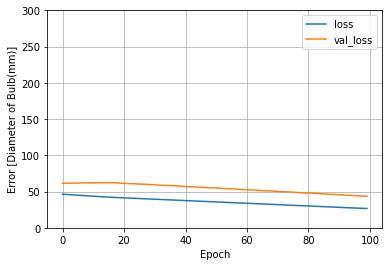

In [35]:
plot_loss(history)

Collect the results on the test set for later:

In [36]:
test_results['linear_model'] = linear_model.evaluate(
    test_features, test_labels, verbose=0)

## Regression with a deep neural network (DNN)

In the previous section, you implemented two linear models for single and multiple inputs.

Here, you will implement single-input and multiple-input DNN models.

The code is basically the same except the model is expanded to include some "hidden" non-linear layers. The name "hidden" here just means not directly connected to the inputs or outputs.

These models will contain a few more layers than the linear model:

* The normalization layer, as before (with `NL_normalizer` for a single-input model and `normalizer` for a multiple-input model).
* Two hidden, non-linear, `Dense` layers with the ReLU (`relu`) activation function nonlinearity.
* A linear `Dense` single-output layer.

Both models will use the same training procedure so the `compile` method is included in the `build_and_compile_model` function below.

In [37]:
def build_and_compile_model(norm):
  model = keras.Sequential([
      norm,
      layers.Dense(24, activation='relu'),
      layers.Dense(24, activation='relu'),
      layers.Dense(1)
  ])

  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.01))
  return model

### Regression using a DNN and a single input

Create a DNN model with only `'NL'` as input and `NL_normalizer` (defined earlier) as the normalization layer:

In [38]:
dnn_NL_model = build_and_compile_model(NL_normalizer)

This model has quite a few more trainable parameters than the linear models:

In [39]:
dnn_NL_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_1 (Normalizat  (None, 1)                3         
 ion)                                                            
                                                                 
 dense_2 (Dense)             (None, 24)                48        
                                                                 
 dense_3 (Dense)             (None, 24)                600       
                                                                 
 dense_4 (Dense)             (None, 1)                 25        
                                                                 
Total params: 676
Trainable params: 673
Non-trainable params: 3
_________________________________________________________________


Train the model with Keras `Model.fit`:

In [40]:
%%time
history = dnn_NL_model.fit(
    train_features['NL'],
    train_labels,
    validation_split=0.2,
    verbose=0, epochs=100)

Wall time: 4.09 s


This model does slightly better than the linear single-input `NL_model`:

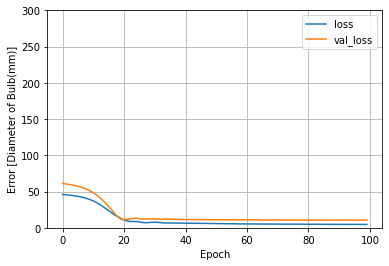

In [41]:
plot_loss(history)

If you plot the predictions as a function of `'NL'`, you should notice how this model takes advantage of the nonlinearity provided by the hidden layers:

In [42]:
x = tf.linspace(0.0, 12, 12)
y = dnn_NL_model.predict(x)

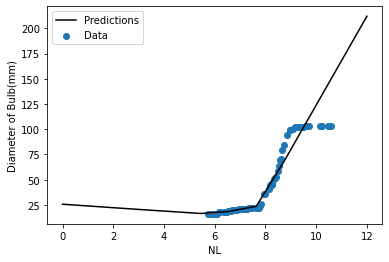

In [43]:
plot_NL(x, y)

Collect the results on the test set for later:

In [44]:
test_results['dnn_NL_model'] = dnn_NL_model.evaluate(
    test_features['NL'], test_labels,
    verbose=0)

### Regression using a DNN and multiple inputs

Repeat the previous process using all the inputs. The model's performance slightly improves on the validation dataset.

In [45]:
dnn_model = build_and_compile_model(normalizer)
dnn_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 11)               23        
 n)                                                              
                                                                 
 dense_5 (Dense)             (None, 24)                288       
                                                                 
 dense_6 (Dense)             (None, 24)                600       
                                                                 
 dense_7 (Dense)             (None, 1)                 25        
                                                                 
Total params: 936
Trainable params: 913
Non-trainable params: 23
_________________________________________________________________


In [46]:
%%time
history = dnn_model.fit(
    train_features,
    train_labels,
    validation_split=0.2,
    verbose=0, epochs=100)

Wall time: 3.03 s


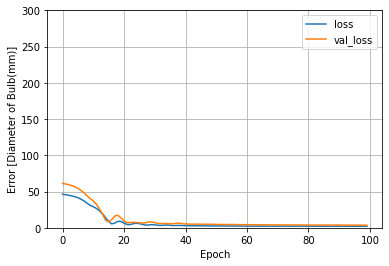

In [47]:
plot_loss(history)

Collect the results on the test set:

In [48]:
test_results['dnn_model'] = dnn_model.evaluate(test_features, test_labels, verbose=0)

## Performance

Since all models have been trained, you can review their test set performance:

In [49]:
pd.DataFrame(test_results, index=['Mean absolute error [Diameter of Bulb(mm)]']).T

,Mean absolute error [Diameter of Bulb(mm)]
NL_model,33.838623
linear_model,32.414352
dnn_NL_model,7.785957
dnn_model,2.617382


These results match the validation error observed during training.

### Make predictions

You can now make predictions with the `dnn_model` on the test set using Keras `Model.predict` and review the loss:

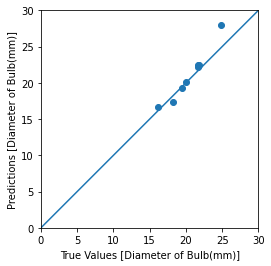

In [50]:
test_predictions = dnn_model.predict(test_features).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [Diameter of Bulb(mm)]')
plt.ylabel('Predictions [Diameter of Bulb(mm)]')
lims = [0, 30]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)


It appears that the model predicts reasonably well.

Now, check the error distribution:

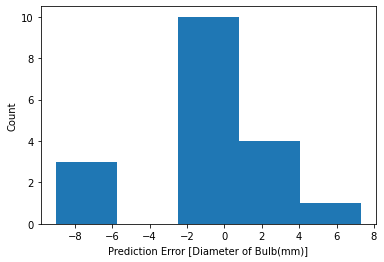

In [51]:
error = test_predictions - test_labels
plt.hist(error, bins=5)
plt.xlabel('Prediction Error [Diameter of Bulb(mm)]')
_ = plt.ylabel('Count')

If you're happy with the model, save it for later use with `Model.save`:

In [52]:
dnn_model.save('dnn_model')

INFO:tensorflow:Assets written to: dnn_model\assets


If you reload the model, it gives identical output:

In [53]:
reloaded = tf.keras.models.load_model('dnn_model')

test_results['reloaded'] = reloaded.evaluate(
    test_features, test_labels, verbose=0)

In [54]:
(pd.DataFrame(test_results, index=['Mean absolute error [Diameter of Bulb(mm)]']).T)

,Mean absolute error [Diameter of Bulb(mm)]
NL_model,33.838623
linear_model,32.414352
dnn_NL_model,7.785957
dnn_model,2.617382
reloaded,2.617382


## Conclusion

This notebook introduced a few techniques to handle a regression problem. Here are a few more tips that may help:

- Mean squared error (MSE) (`tf.keras.losses.MeanSquaredError`) and mean absolute error (MAE) (`tf.keras.losses.MeanAbsoluteError`) are common loss functions used for regression problems. MAE is less sensitive to outliers. Different loss functions are used for classification problems.
- Similarly, evaluation metrics used for regression differ from classification.
- When numeric input data features have values with different ranges, each feature should be scaled independently to the same range.
- Overfitting is a common problem for DNN models, though it wasn't a problem for this tutorial. Visit the [Overfit and underfit](overfit_and_underfit.ipynb) tutorial for more help with this.

In [56]:
import numpy as np
import pandas as pd
import statsmodels.api as sm

In [57]:
df = pd.read_csv('AER_G_dataset-PTC.csv')
x = df.iloc[:,:-1].values
#y = df.iloc[:,1].values
y = df[['Diameter of Bulb(mm)']]
#x = [[0, 1], [5, 1], [15, 2], [25, 5], [35, 11], [45, 15], [55, 34], [60, 35] ]
#y = [4, 5, 20, 14, 32, 22, 38, 43]
x, y = np.array(x), np.array(y)
df

,DAT(days),Temp,WC,NL,N(PTC) (mg/g),P(PTC) (mg/g),K(PTC) (mg/g),Ca(PTC) (mg/g),Mg(PTC) (mg/g),S(PTC) (mg/g),Na(PTC) (mg/g),Diameter of Bulb(mm)
0,1,18.3,0.11,5.75,33.56,4.90,37.29,7.25,2.13,1.93,0.77,16.03
1,2,19.8,0.22,5.79,34.38,4.91,38.62,7.46,2.14,1.95,0.78,16.04
2,3,18.3,0.31,5.83,34.60,5.01,39.81,7.69,2.15,1.97,0.79,16.05
3,4,16.9,0.42,5.87,35.61,5.02,40.65,7.82,2.16,1.99,0.80,16.06
4,6,18.9,0.56,5.91,36.62,5.03,42.15,7.01,2.18,2.00,0.81,16.07
...,...,...,...,...,...,...,...,...,...,...,...,...
86,89,29.5,15.18,10.23,43.02,7.56,50.64,14.06,1.83,3.72,1.99,103.39
87,90,27.9,15.21,10.34,43.00,7.64,50.43,14.07,1.84,3.73,2.00,103.47
88,91,27.1,15.27,10.48,42.82,7.68,50.27,14.08,1.85,3.74,2.01,103.49
89,92,26.1,15.30,10.51,42.61,7.72,49.94,14.09,1.86,3.75,2.02,103.52


In [58]:
x = sm.add_constant(x)

In [59]:
# Create a model and fit it,The regression model based on ordinary least squares is an instance of the class statsmodels.
#regression.linear_model
model = sm.OLS(y, x)

In [60]:
# By calling .fit(), you obtain the variable results, which is an instance of the class statsmodels.
# regression.linear_model.RegressionResultsWrapper.
results = model.fit()

In [61]:
#call .summary() to get the table with the results of linear regression
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.995
Model:                            OLS   Adj. R-squared:                  0.994
Method:                 Least Squares   F-statistic:                     1315.
Date:                Mon, 06 Jun 2022   Prob (F-statistic):           1.31e-84
Time:                        19:11:02   Log-Likelihood:                -217.50
No. Observations:                  91   AIC:                             459.0
Df Residuals:                      79   BIC:                             489.1
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -75.8834     87.943     -0.863      0.3

In [62]:
# To get rsquared, rsquared_adj, param
print(f"coefficient of determination: {results.rsquared}")
print(f"adjusted coefficient of determination: {results.rsquared_adj}")
print(f"regression coefficients: {results.params}")

coefficient of determination: 0.9945676122779628
adjusted coefficient of determination: 0.9938112038609702
regression coefficients: [-75.883  -3.421  -0.532  13.623   0.69    0.434  -7.554   0.243  -4.951
  14.494 -37.277 248.387]


In [63]:
#To get predicted values for the input values
#print(f"predicted response:\n{results.fittedvalues}")
Bulb_pred = results.predict(x)
print(f"predicted response:\n{results.predict(x)}")

predicted response:
[ 17.334  16.089  15.093  15.749  16.917  12.912  13.023  11.691  18.914
  18.395  18.417  18.396  19.935  19.422  18.8    19.186  19.985  21.117
  20.793  18.371  18.783  17.821  19.936  20.172  19.954  20.857  20.69
  20.426  15.727  16.5    16.978  18.65   19.804  20.497  21.294  21.988
  23.167  19.678  25.361  23.903  25.369  26.937  28.096  27.544  25.727
  24.618  25.774  25.676  38.05   36.689  43.465  45.478  46.656  47.333
  50.571  46.345  51.115  58.054  65.508  68.588  68.69   70.983  78.383
  85.311  89.395  88.724  88.453  90.155  92.899  94.409  97.349  98.845
 101.425 103.197 103.846 103.333 102.761 101.487 103.185 102.023 101.917
  99.885 106.279 106.328 105.311 105.446 104.256 103.713 103.419 102.692
 101.753]


<function matplotlib.pyplot.show(close=None, block=None)>

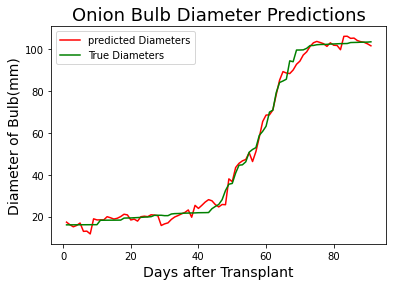

In [64]:
import matplotlib.pyplot as plt
import numpy as np

x = np.arange(1, 92, 1)
#y = 
z = Bulb_pred
#plt.plot(x, y)
plt.plot(x, z, color='r', label='predicted Diameters')
plt.plot(x, y, color='g', label='True Diameters')
plt.ylabel('Diameter of Bulb(mm)', fontsize=14)
plt.xlabel('Days after Transplant', fontsize=14)

plt.title('Onion Bulb Diameter Predictions', fontsize=18)
plt.legend()
plt.show


In [68]:
!pip install rfpimp

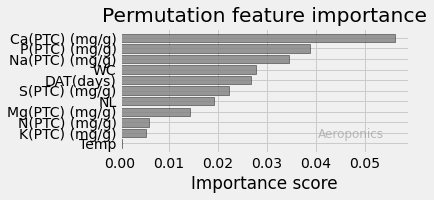

In [69]:
import rfpimp
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

######################################## Data preparation #########################################

#file = 'https://aegis4048.github.io/downloads/notebooks/sample_data/unconv_MV_v5.csv'
#df = pd.read_csv(file)
features = ['DAT(days)','Temp','WC','NL','N(PTC) (mg/g)','P(PTC) (mg/g)','K(PTC) (mg/g)','Ca(PTC) (mg/g)','Mg(PTC) (mg/g)','S(PTC) (mg/g)','Na(PTC) (mg/g)','Diameter of Bulb(mm)']

######################################## Train/test split #########################################

df_train, df_test = train_test_split(df, test_size=0.20)
df_train = df_train[features]
df_test = df_test[features]

X_train, y_train = df_train.drop('Diameter of Bulb(mm)',axis=1), df_train['Diameter of Bulb(mm)']
X_test, y_test = df_test.drop('Diameter of Bulb(mm)',axis=1), df_test['Diameter of Bulb(mm)']

################################################ Train #############################################

rf = RandomForestRegressor(n_estimators=100, n_jobs=-1)
rf.fit(X_train, y_train)

############################### Permutation feature importance #####################################

imp = rfpimp.importances(rf, X_test, y_test)

############################################## Plot ################################################

fig, ax = plt.subplots(figsize=(6, 3))

ax.barh(imp.index, imp['Importance'], height=0.8, facecolor='grey', alpha=0.8, edgecolor='k')
ax.set_xlabel('Importance score')
ax.set_title('Permutation feature importance')
ax.text(0.8, 0.15, 'Aeroponics', fontsize=12, ha='center', va='center',
        transform=ax.transAxes, color='grey', alpha=0.5)
plt.gca().invert_yaxis()

fig.tight_layout()